/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(60000, 784)


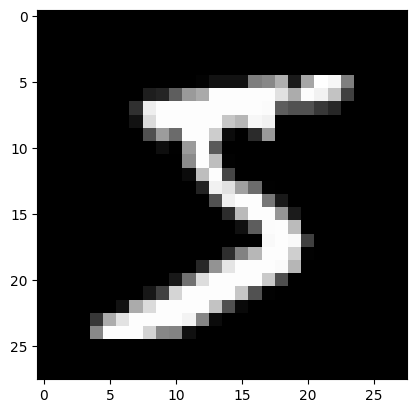

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import homogeneity_score


mnist = fetch_openml('mnist_784')
X=  mnist.data.to_numpy().astype(float)
X= X / 255.0
x_train= X[:60000]
x_test= X[60000:]
y= mnist.target.astype(int)
y_train= y[:60000]
y_test= y[60000:]
print(X.shape)
print(x_train.shape)
plt.imshow(x_train[0].reshape(28,28), cmap='gray')

In [2]:
def pca_compress(data, num_components):
    mean = np.mean(data, axis=0)
    centered_data = data - mean
    covariance_matrix = np.cov(centered_data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    q_matrix = eigenvectors[:, :num_components]
    compressed_data = np.dot(centered_data, q_matrix)
    return centered_data, compressed_data, q_matrix, mean

def decompression(compressed_data, q_matrix, mean):
    reconstructed_data = np.dot(compressed_data, q_matrix.T) + mean
    return reconstructed_data

In [3]:
min_error = 0.0001
n_components = 0
best_q = 0
for k in range(0, x_train.shape[1], 5):  # Iterate over the number of features
    centered, constructed, q_matrix, mean = pca_compress(x_train, k)
    reconstructed = decompression(constructed, q_matrix, mean)
    error = np.mean((x_train - reconstructed) ** 2)
    if error < min_error:
        n_components = k
        best_q = q_matrix
        print(f"Number of components: {n_components}")
        print("Reconstruction Error:", error)
        break
print ('centered image shape: ',centered.shape)
print('constructed image shape: ',constructed.shape)
print('reconstructed image shape: ',reconstructed.shape)
print('best Q shape: ',best_q.shape)



Number of components: 465
Reconstruction Error: 9.841584120012423e-05
centered image shape:  (60000, 784)
constructed image shape:  (60000, 465)
reconstructed image shape:  (60000, 784)
best Q shape:  (784, 465)


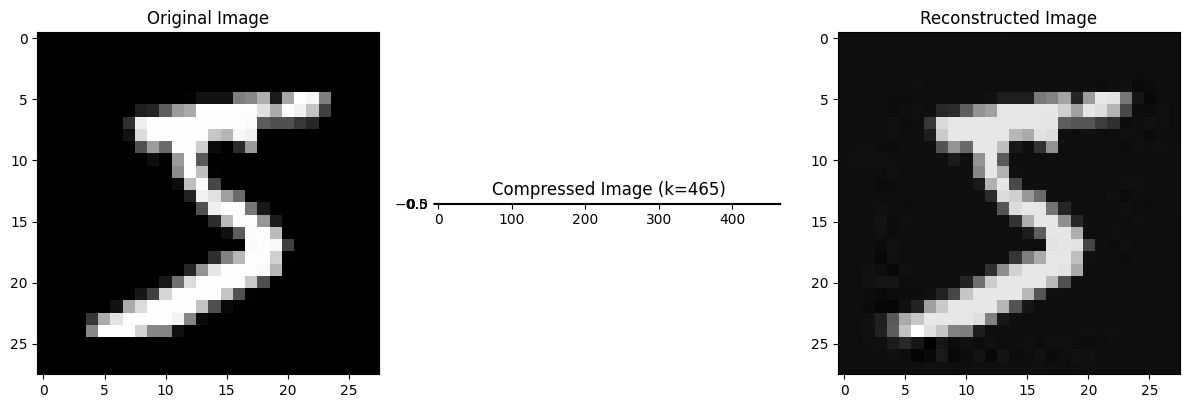

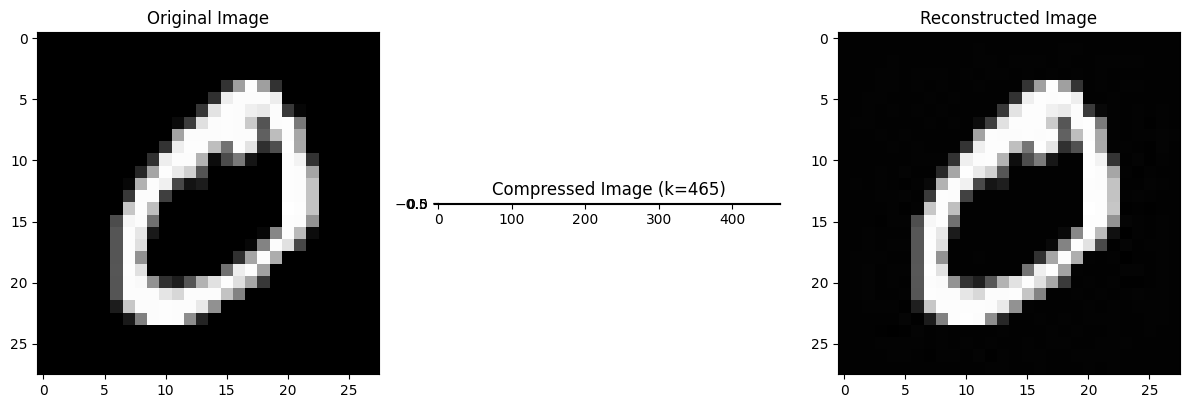

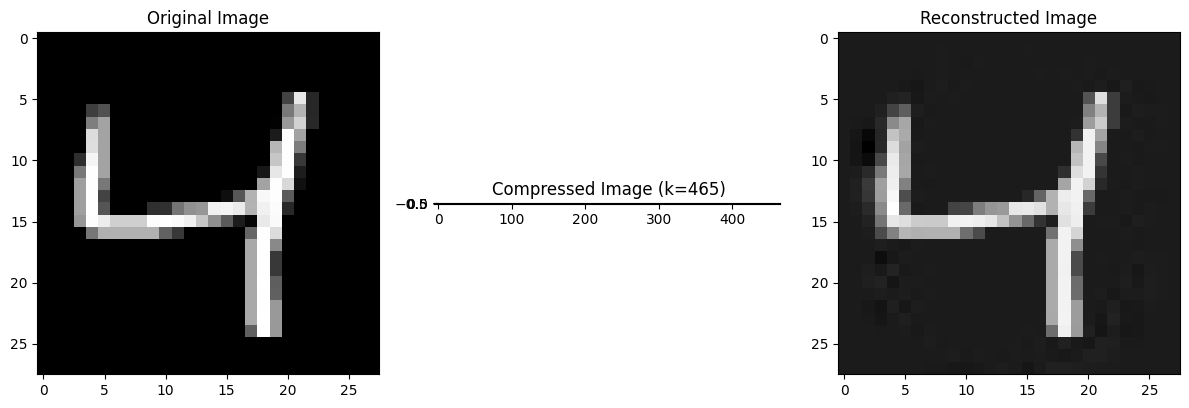

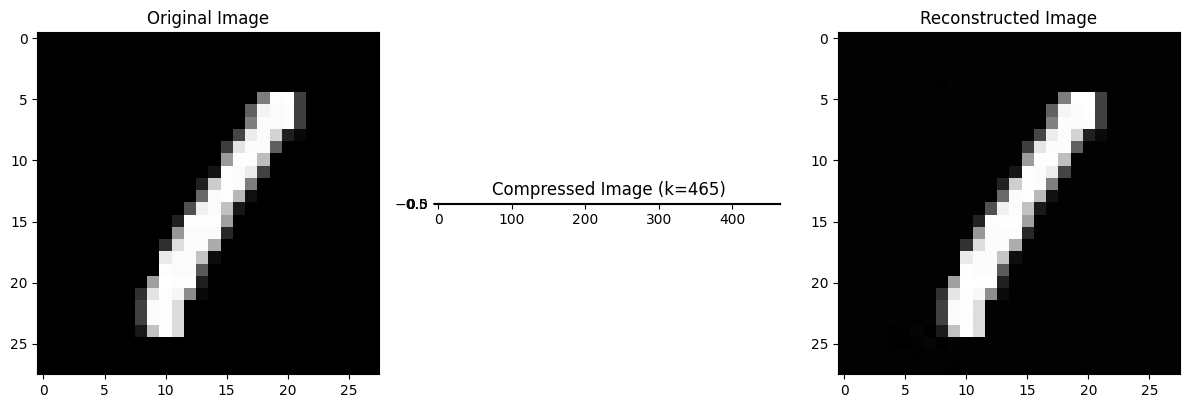

In [4]:
for i in range(4):
    plt.figure(figsize=(12, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title('Original Image')

    # Compressed Image
    plt.subplot(1, 3, 2)
    plt.imshow(constructed[i].reshape(1, -1), cmap='gray')  # Reshape to a single row
    plt.title(f'Compressed Image (k={k})')

    # Reconstructed Image
    plt.subplot(1, 3, 3)
    plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    plt.title('Reconstructed Image')

    plt.tight_layout()
    plt.show()


In [5]:
def retrieve_info(cluster_assignments,y_train):
   reference_labels = {}
   # For each label of cluster label
   for i in range(len(np.unique(cluster_assignments))):
      index = np.where(cluster_assignments == i,1,0)
      num = np.bincount(y_train[index==1]).argmax()
      reference_labels[i] = num
   return reference_labels

In [6]:
#k-means before PCA
kmeans_original = MiniBatchKMeans(n_clusters = 256 ,random_state=1)
cluster_assignments= kmeans_original.fit_predict(x_train)

reference_labels = retrieve_info(cluster_assignments,y_train)
y_pred = np.random.rand(len(cluster_assignments))
for i in range(len(cluster_assignments)):
  y_pred[i] = reference_labels[cluster_assignments[i]]

print('cluster_assignments: ',cluster_assignments[:30])

# Comparing Predicted values and Actual values
print('y predict: ',y_pred[:30].astype('int'))
print('y        : ',np.array(y_train[:30]))

print('k-means Accuracy without PCA: ',accuracy_score(y_pred,y_train))
print('k-means Homogeneity without PCA: ', homogeneity_score(y_train, cluster_assignments))

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster_assignments:  [ 83 147  79 158 112 186  51  73 118 155 126 204 198  52 118 135 229 219
  41 190  79  87 155 158 185 226  21 144 242 213]
y predict:  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 4 1 3 2 9 3 7 9]
y        :  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]
k-means Accuracy without PCA:  0.8993333333333333
k-means Homogeneity without PCA:  0.843671799197552


(256, 28, 28)


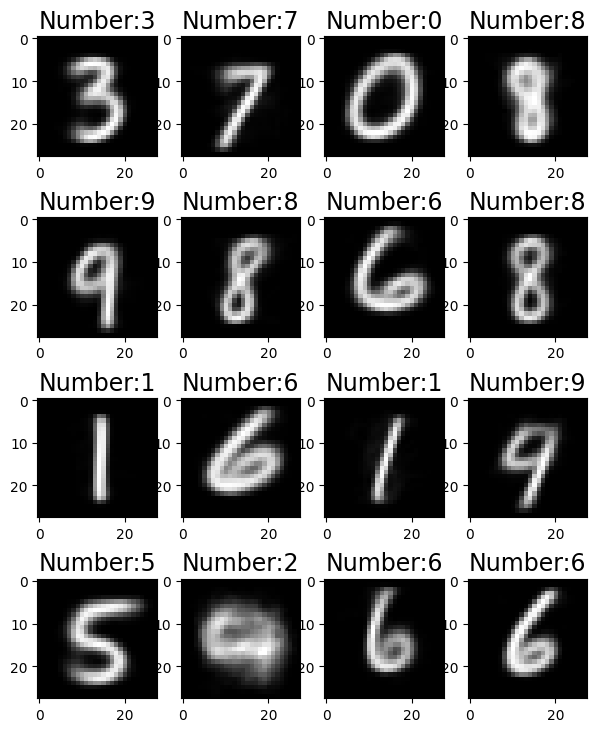

In [7]:
centroids = kmeans_original.cluster_centers_.reshape(256,28,28)
print(centroids.shape)
centroids = centroids * 255

plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(16):
 plt.subplots_adjust(bottom)
 plt.subplot(4,4,i+1)
 plt.title('Number:{}'.format(reference_labels[i]),fontsize = 17)
 plt.imshow(centroids[i], cmap='gray')

In [8]:
#k-means after PCA
kmeans_compressed = MiniBatchKMeans(n_clusters=256, random_state=1)
cluster_assignments= kmeans_compressed.fit_predict(constructed)

reference_labels = retrieve_info(cluster_assignments,y_train)
y_pred = np.random.rand(len(cluster_assignments))
for i in range(len(cluster_assignments)):
  y_pred[i] = reference_labels[cluster_assignments[i]]

print('cluster_assignments: ',cluster_assignments[:30])
# Comparing Predicted values and Actual values
print('y predict: ',y_pred[:30].astype('int'))
print('y        : ', np.array(y_train[:30]))

print (len(cluster_assignments))
print (len(y_pred))
print (len(y_train))
print('k-means Accuracy with PCA: ',accuracy_score(y_pred,y_train))
print('k-means Homogeneity without PCA: ', homogeneity_score(y_train, cluster_assignments))

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster_assignments:  [219 246 160  13 147  67  32 180  32   8  93  40 137 235   2  86 144  91
 226   9  29 246  88  13 239 215   5 211 126  70]
y predict:  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 7 4 0 9 1 2 2 9 3 2 7]
y        :  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]
60000
60000
60000
k-means Accuracy with PCA:  0.8973
k-means Homogeneity without PCA:  0.842304618636933


In [9]:
#k-means reconstructed after PCA
kmeans_reconstructed = MiniBatchKMeans(n_clusters = 256 ,random_state=1)
cluster_assignments= kmeans_reconstructed.fit_predict(reconstructed)

reference_labels = retrieve_info(cluster_assignments,y_train)
y_pred = np.random.rand(len(cluster_assignments))
for i in range(len(cluster_assignments)):
  y_pred[i] = reference_labels[cluster_assignments[i]]

print('cluster_assignments: ',cluster_assignments[:30])

# Comparing Predicted values and Actual values
print('y predict: ',y_pred[:30].astype('int'))
print('y        : ',np.array(y_train[:30]))

print('k-means Accuracy without PCA: ',accuracy_score(y_pred,y_train))
print('k-means Homogeneity without PCA: ', homogeneity_score(y_train, cluster_assignments))

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


cluster_assignments:  [219 246 160  13 147  67  32 180  32   8  93  40 137 235   2  86 144  91
 226   9  29 246  88  13 239 215   5 211 126  70]
y predict:  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 7 4 0 9 1 2 2 9 3 2 7]
y        :  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]
k-means Accuracy without PCA:  0.8973
k-means Homogeneity without PCA:  0.842304618636933


In [10]:
weights = kmeans_original.cluster_centers_
print(weights.shape)
learning_rate = 0.01
epochs = 10

for epoch in range(epochs):
    for i in range(len(x_train)):

        input_sample = x_train[i]

        distances = np.linalg.norm(weights - input_sample, axis=1)
        # print(distances.shape)
        winner_index = np.argmin(distances)

        weights[winner_index] += learning_rate * (input_sample - weights[winner_index])

cluster_assignments_original = [np.argmin(np.linalg.norm(weights - x, axis=1)) for x in x_train]

cluster_assignments_original= np.array(cluster_assignments_original)

reference_labels = retrieve_info(cluster_assignments_original,y_train)
y_pred = np.random.rand(len(cluster_assignments_original))
for i in range(len(cluster_assignments_original)):
  y_pred[i] = reference_labels[cluster_assignments_original[i]]

# Comparing Predicted values and Actual values
print('y predict: ',y_pred[:30].astype('int'))
print('y        : ', np.array(y_train[:30]))
print('SCN Accuracy before PCA: ',accuracy_score(y_pred,y_train))
print('SCN Homogeneity before PCA: ', homogeneity_score(y_train, cluster_assignments_original))

(256, 784)
y predict:  [5 0 4 1 4 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 2 2 9 3 7 7]
y        :  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]
SCN Accuracy before PCA:  0.9112833333333333
SCN Homogeneity before PCA:  0.8564259878541532


(256, 28, 28)


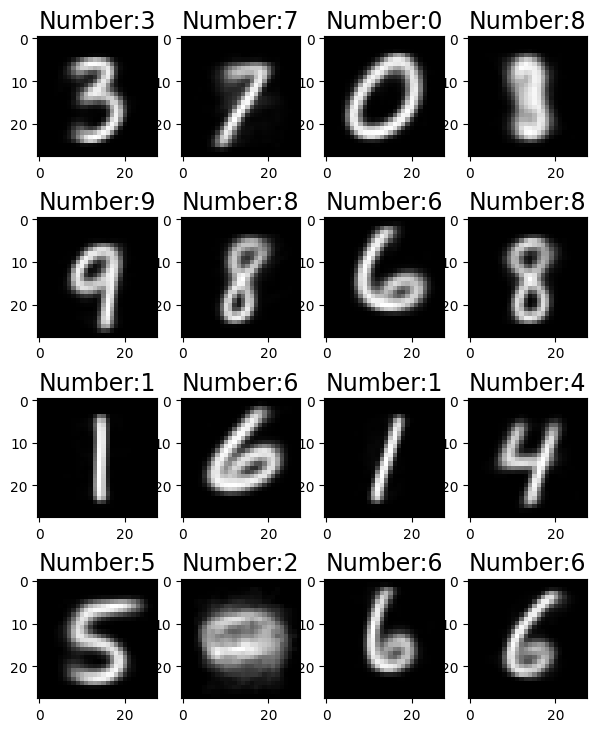

In [11]:
centroids = weights.reshape(weights.shape[0],28,28)
print(centroids.shape)

centroids = centroids * 255
plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(16):
 plt.subplots_adjust(bottom)
 plt.subplot(4,4,i+1)
 plt.title('Number:{}'.format(reference_labels[i]),fontsize = 17)
 plt.imshow(centroids[i], cmap='gray')

In [12]:
weights = kmeans_compressed.cluster_centers_

learning_rate = 0.01
epochs = 10


# Training the Competitive Network
for epoch in range(epochs):
    for i in range(len(constructed)):
        # Select a random input sample
        input_sample = constructed[i]

        # Compute the Euclidean distances between the input and weight vectors
        distances = np.linalg.norm(weights - input_sample, axis=1)

        # Find the index of the winning neuron (closest weight vector)
        winner_index = np.argmin(distances)

        # Update the weights of the winner
        weights[winner_index] += learning_rate * (input_sample - weights[winner_index])

# Assign each input to the cluster with the closest weight vector
cluster_assignments_compressed = [np.argmin(np.linalg.norm(weights - x, axis=1)) for x in constructed]

cluster_assignments_compressed= np.array(cluster_assignments_compressed)

reference_labels = retrieve_info(cluster_assignments_compressed,y_train)
y_pred = np.random.rand(len(cluster_assignments_compressed))
for i in range(len(cluster_assignments_compressed)):
  y_pred[i] = reference_labels[cluster_assignments_compressed[i]]

# Comparing Predicted values and Actual values
print('y predict: ',y_pred[:30].astype('int'))
print('y        : ', np.array(y_train[:30]))

print('SCN Accuracy after PCA: ',accuracy_score(y_pred,y_train))
print('SCN Homogeneity after PCA: ', homogeneity_score(y_train, cluster_assignments_compressed))

y predict:  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 2 2 4 3 2 7]
y        :  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]
SCN Accuracy after PCA:  0.9144833333333333
SCN Homogeneity after PCA:  0.8572519918218239


In [13]:
weights = kmeans_reconstructed.cluster_centers_

learning_rate = 0.01
epochs = 10


# Training the Competitive Network
for epoch in range(epochs):
    for i in range(len(reconstructed)):
        # Select a random input sample
        input_sample = reconstructed[i]

        # Compute the Euclidean distances between the input and weight vectors
        distances = np.linalg.norm(weights - input_sample, axis=1)

        # Find the index of the winning neuron (closest weight vector)
        winner_index = np.argmin(distances)

        # Update the weights of the winner
        weights[winner_index] += learning_rate * (input_sample - weights[winner_index])

# Assign each input to the cluster with the closest weight vector
cluster_assignments_decompressed = [np.argmin(np.linalg.norm(weights - x, axis=1)) for x in reconstructed]

cluster_assignments_decompressed= np.array(cluster_assignments_decompressed)

reference_labels = retrieve_info(cluster_assignments_decompressed,y_train)
y_pred = np.random.rand(len(cluster_assignments_decompressed))
for i in range(len(cluster_assignments_decompressed)):
  y_pred[i] = reference_labels[cluster_assignments_decompressed[i]]

# Comparing Predicted values and Actual values
print('y predict: ',y_pred[:30].astype('int'))
print('y        : ', np.array(y_train[:30]))

print('SCN Accuracy after PCA: ',accuracy_score(y_pred,y_train))
print('SCN Homogeneity after PCA: ', homogeneity_score(y_train, cluster_assignments_decompressed))

y predict:  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 2 2 4 3 2 7]
y        :  [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9 4 0 9 1 1 2 4 3 2 7]
SCN Accuracy after PCA:  0.9144833333333333
SCN Homogeneity after PCA:  0.8572519918218239
